In [29]:
# Fraud Detection using Machine Learning 
#     - Data Cleaning, shuffling, scaling and outliers handling
#     - Balancing the data for equated weightage on both genuine and fraud classes
#     - Fitting a Random Forest Classifier to train the model on genuine and fraudulent transactions

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

%matplotlib inline
import warnings

warnings.filterwarnings('ignore') #ignore warnings message

df = pd.read_csv(r"file:///E:\DS\Credit_Card\creditcard.csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [30]:
df.shape

(284807, 31)

In [31]:
df.isnull().sum().max()

0

In [32]:
# the classes are heavily skewed we need to solve the issue later
print('No Frauds', round(df['Class'].value_counts()[0]/len(df)*100,2), '% of the dataset')

No Frauds 99.83 % of the dataset


In [33]:
print('Frauds', round(df['Class'].value_counts()[1]/len(df)*100,2), '% of the dataset')

Frauds 0.17 % of the dataset


Text(0.5, 1.0, 'Class distribution \n (0:no fraud, 1: fraud)')

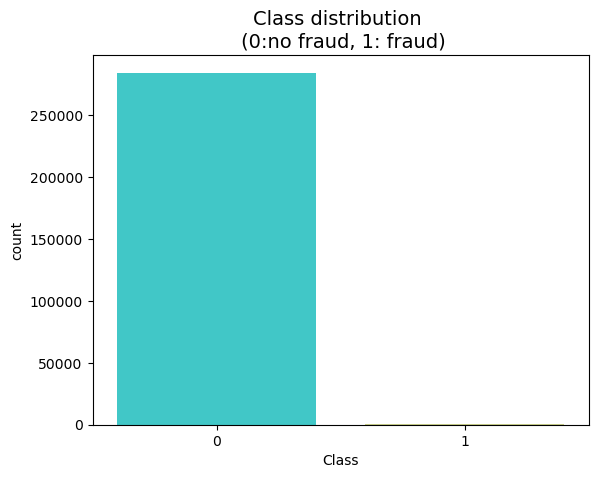

In [34]:
sns.countplot(x='Class', data=df, palette='rainbow')
plt.title('Class distribution \n (0:no fraud, 1: fraud)',fontsize=14)

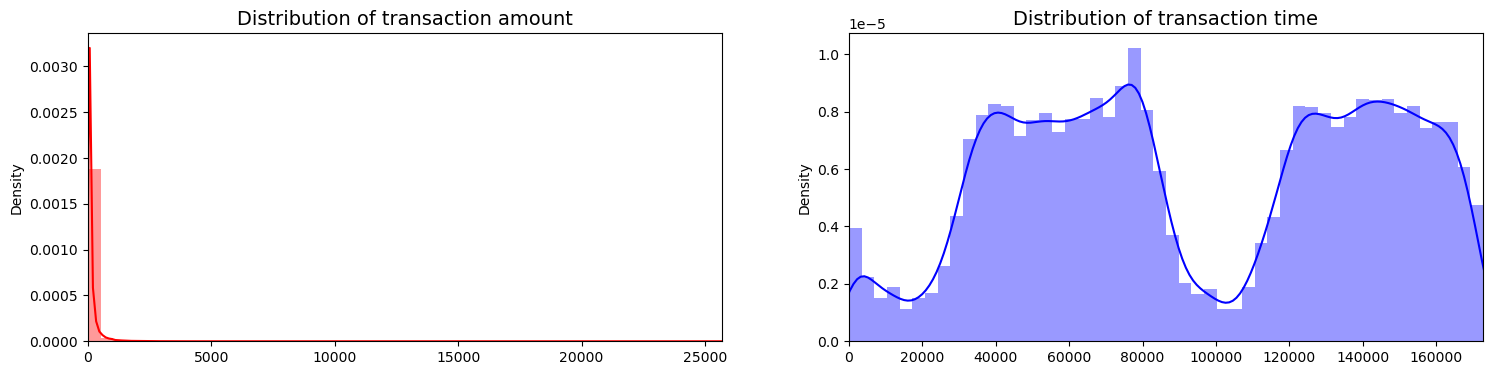

In [35]:
fig, ax = plt.subplots(1, 2, figsize=(18,4))

amount_val = df['Amount'].values
time_val = df['Time'].values

sns.distplot(amount_val, ax=ax[0], color='r')
ax[0].set_title('Distribution of transaction amount', fontsize=14)
ax[0].set_xlim([min(amount_val), max(amount_val)])

sns.distplot(time_val, ax=ax[1], color='b')
ax[1].set_title('Distribution of transaction time', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])

plt.show()

In [36]:
# Since most of the data is already scaled we should scale that are left to scale ( amount and time)
from sklearn.preprocessing import RobustScaler

# Robustscaler is less prone to outliers
rob_scaler = RobustScaler()

df['scaled_amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1,1))

df.drop(['Time','Amount'], axis=1, inplace=True)


In [37]:
scaled_amount = df['scaled_amount']
scaled_time = df['scaled_time']

df.drop(['scaled_amount', 'scaled_time'], axis=1, inplace=True)
df.insert(0, 'scaled_amount', scaled_amount)
df.insert(1, 'scaled_time', scaled_time)

# amount and time are scaled
df.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,1.783274,-0.994983,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.269825,-0.994983,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,4.983721,-0.994972,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,1.418291,-0.994972,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,0.670579,-0.994960,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


In [38]:
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold, KFold

In [39]:
x = df.drop('Class', axis=1)
y = df['Class']

In [40]:
sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

In [41]:
for train_index, test_index in sss.split(x,y):
    original_xtrain, original_xtest = x.iloc[train_index], x.iloc[test_index]
    original_ytrain, original_ytest = x.iloc[train_index], x.iloc[test_index]

In [42]:
# lets shuffle the data before creating the subsamples

df = df.sample(frac=1)

# amount of fraud classes 492 rows
fraud_df = df.loc[df['Class'] == 1]
non_fraud_df = df.loc[df['Class'] == 0] [0:492]

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

In [43]:
# Shuffle dataframe rows
new_df = normal_distributed_df.sample(frac=1, random_state=42)

In [44]:
new_df

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
95333,-0.125900,-0.228292,-0.402063,0.429620,2.538726,0.535255,-0.242769,0.737030,0.087586,0.285867,...,-0.074341,0.036185,0.397237,-0.155242,-0.015643,-0.207038,-0.462955,-0.033756,-0.160282,0
77387,5.899113,-0.325016,-2.335655,2.225380,-3.379450,2.178538,-3.568264,0.316814,-1.734948,1.449139,...,0.274027,0.785540,0.297412,0.308536,-0.598416,-0.121850,-0.491018,0.701606,0.206966,1
170030,-0.028226,0.414655,-0.605167,0.683896,0.889570,-0.581989,0.722891,-0.499557,0.881476,-0.108057,...,-0.051564,-0.299231,-0.867095,0.300829,-0.398252,-0.597465,-0.842830,0.066264,0.138910,0
43428,4.781527,-0.507372,-16.526507,8.584972,-18.649853,9.505594,-13.793819,-2.832404,-16.701694,7.517344,...,-1.514923,1.190739,-1.127670,-2.358579,0.673461,-1.413700,-0.462762,-2.018575,-1.042804,1
154694,4.540488,0.210646,-2.877176,4.569649,-9.553069,4.441079,-3.653961,-1.877981,-3.514353,1.547608,...,0.105615,1.272896,1.300268,-0.003950,-0.360848,-0.597526,-0.390901,0.592197,-0.241010,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261925,1.872424,0.887593,-2.783865,1.596824,-2.084844,2.512986,-1.446749,-0.828496,-0.732262,-0.203329,...,-0.515001,0.203563,0.293268,0.199568,0.146868,0.163602,-0.624085,-1.333100,0.428634,1
12070,-0.293440,-0.749081,-16.367923,9.223692,-23.270631,11.844777,-9.462037,-2.450444,-16.925152,1.384208,...,0.993585,-2.343674,1.004602,1.188212,-1.047184,-0.035573,0.664900,2.122796,-1.416741,1
179683,3.163558,0.464080,-2.518094,-1.035174,0.246825,0.009865,0.591758,-0.690629,0.683770,0.579017,...,0.863260,0.049221,-0.857124,0.218640,-0.477717,0.782149,-0.325555,0.079126,-0.182083,0
223366,-0.293440,0.689176,1.118331,2.074439,-3.837518,5.448060,0.071816,-1.020509,-1.808574,0.521744,...,0.163513,0.289861,-0.172718,-0.021910,-0.376560,0.192817,0.114107,0.500996,0.259533,1


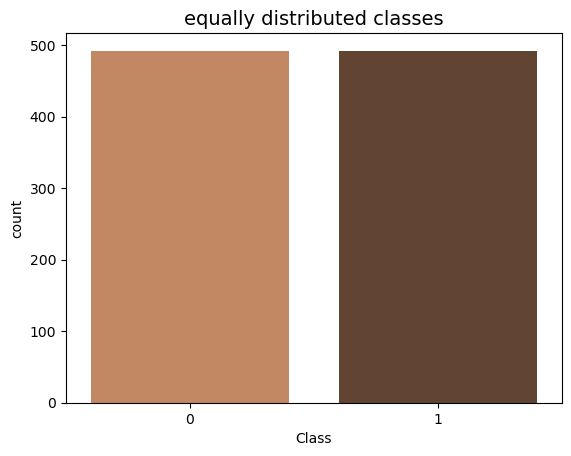

In [45]:
sns.countplot(x='Class', data=new_df, palette='copper_r')
plt.title('equally distributed classes',fontsize=14)
plt.show()

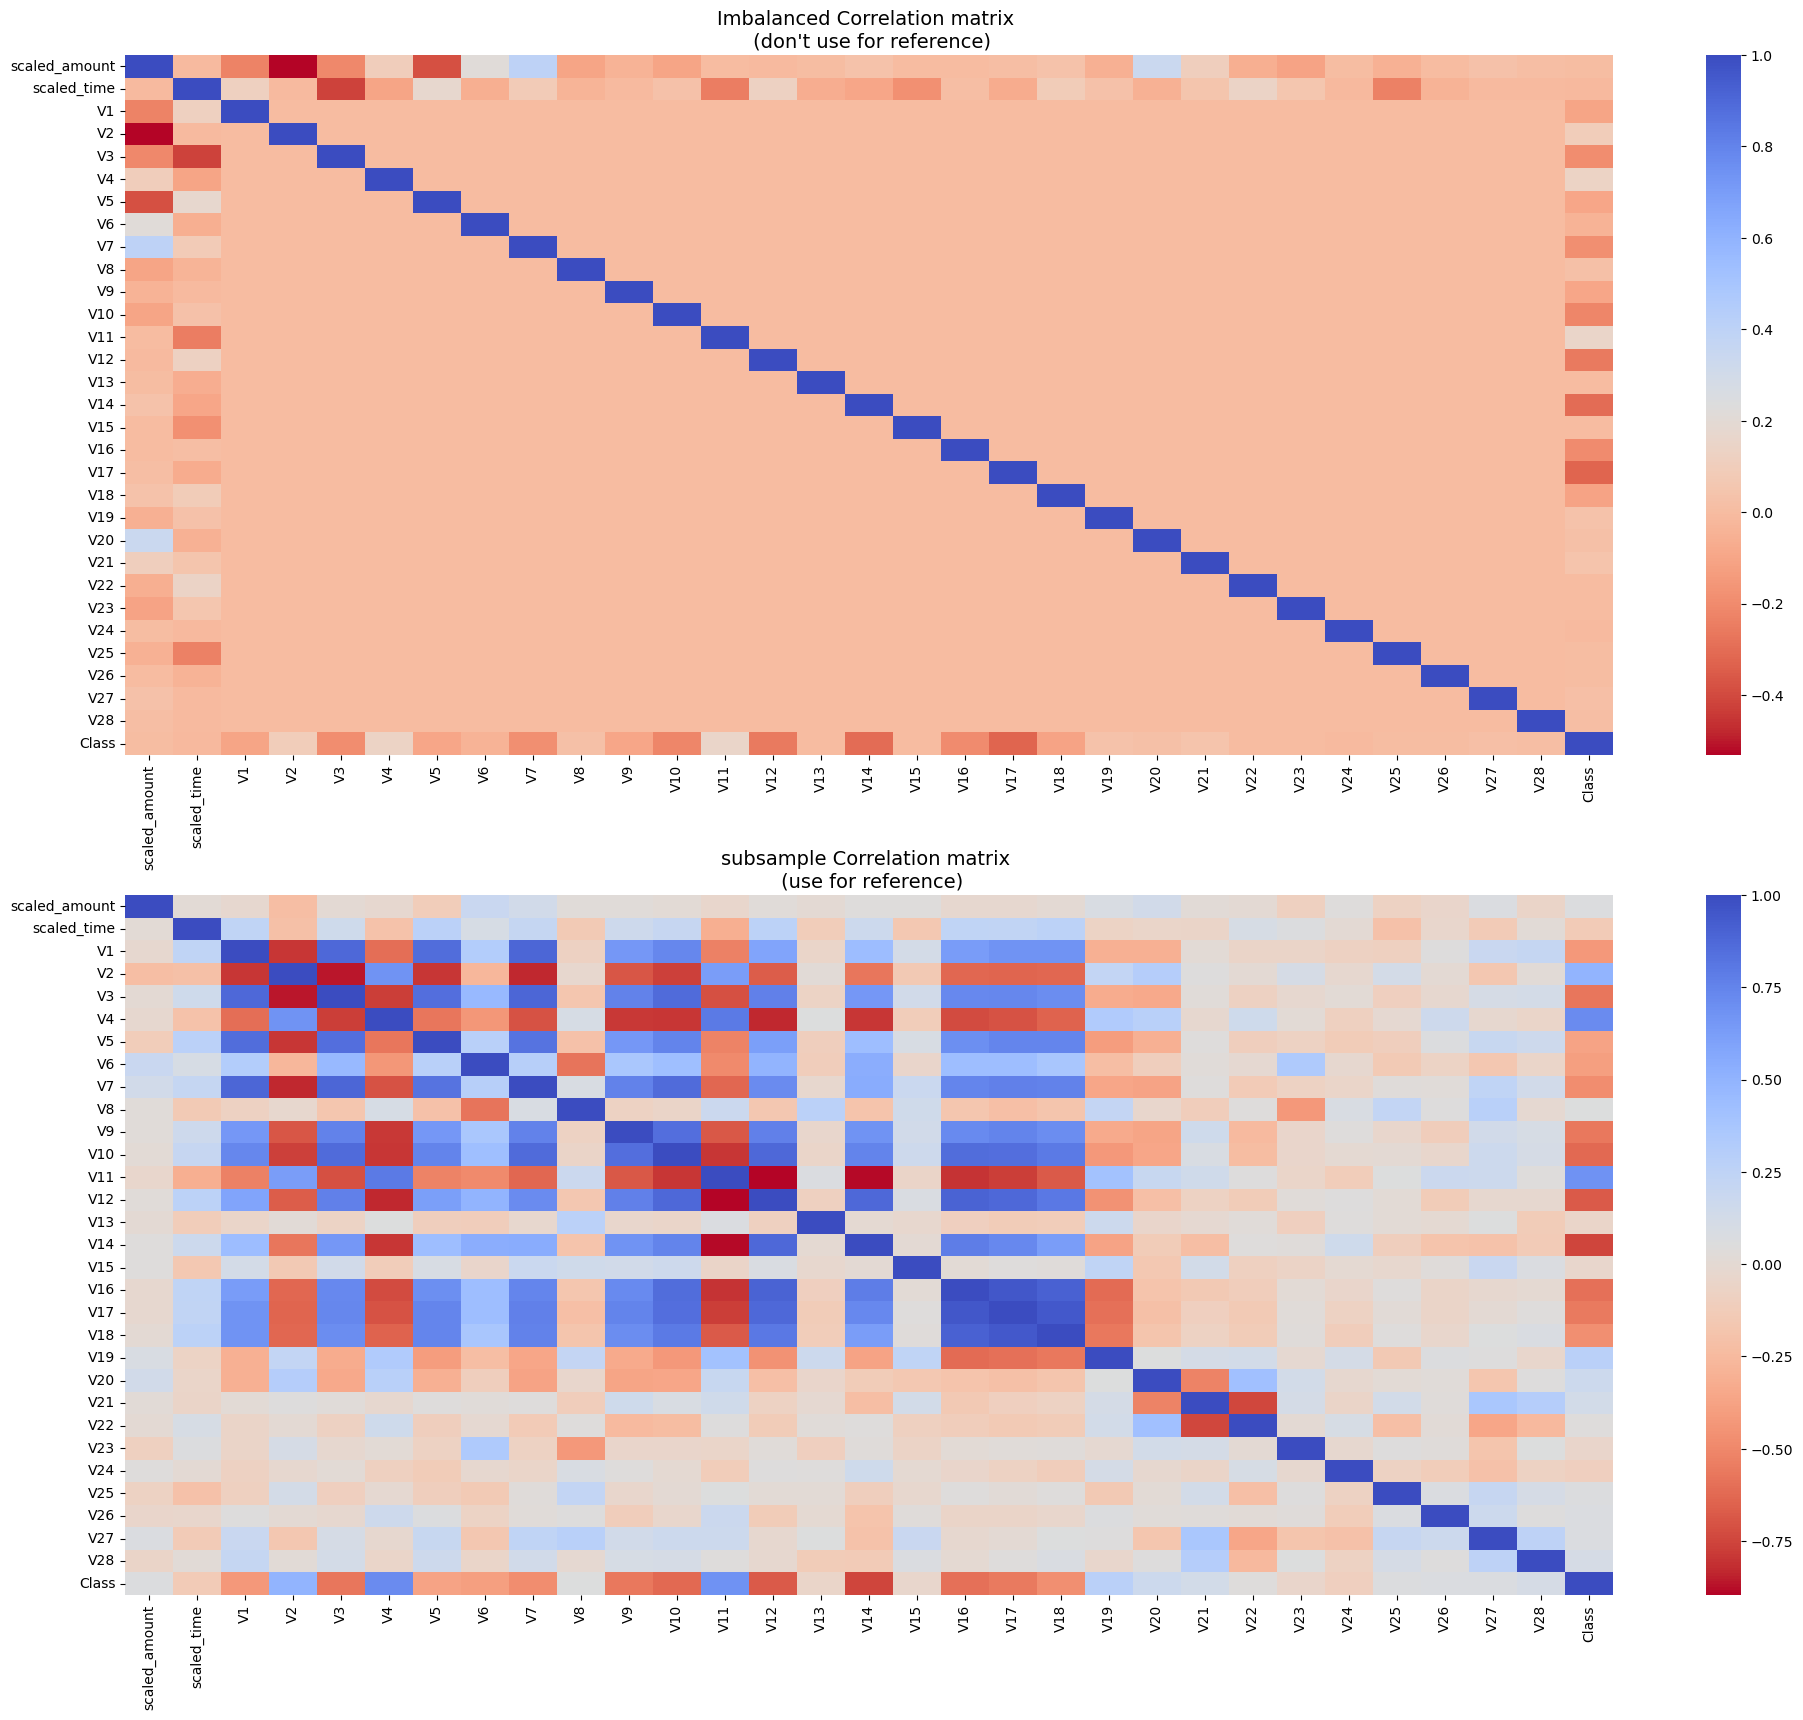

In [46]:
# Correlation matrix

f, (ax1, ax2) = plt.subplots(2, 1, figsize=(24,20))

corr  = df.corr()
sns.heatmap(corr, cmap = 'coolwarm_r', annot_kws={'size' : 20}, ax=ax1)
ax1.set_title("Imbalanced Correlation matrix \n (don't use for reference)", fontsize=14)

sub_sample_corr = new_df.corr()
sns.heatmap(sub_sample_corr, cmap='coolwarm_r', annot_kws={'size' : 20}, ax=ax2)
ax2.set_title("subsample Correlation matrix \n (use for reference)", fontsize=14)

plt.show()


Text(0.5, 1.0, 'V10 vs Class negative Corrleation')

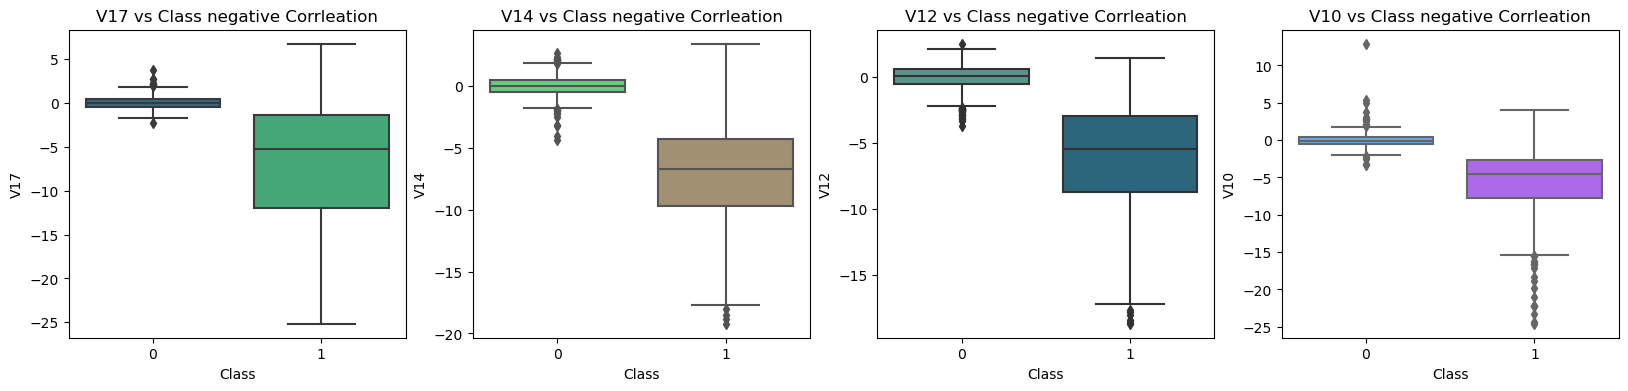

In [47]:
f, axes = plt.subplots(ncols=4, figsize=(20,4))

# negative correlation with our class ( the lower our feature value the more likely it willl be a fraud txn)
sns.boxplot(x="Class", y="V17", data=new_df, palette="viridis", ax=axes[0])
axes[0].set_title("V17 vs Class negative Corrleation")

sns.boxplot(x="Class", y="V14", data=new_df, palette="terrain", ax=axes[1])
axes[1].set_title("V14 vs Class negative Corrleation")

sns.boxplot(x="Class", y="V12", data=new_df, palette="crest", ax=axes[2])
axes[2].set_title("V12 vs Class negative Corrleation")

sns.boxplot(x="Class", y="V10", data=new_df, palette="cool", ax=axes[3])
axes[3].set_title("V10 vs Class negative Corrleation")




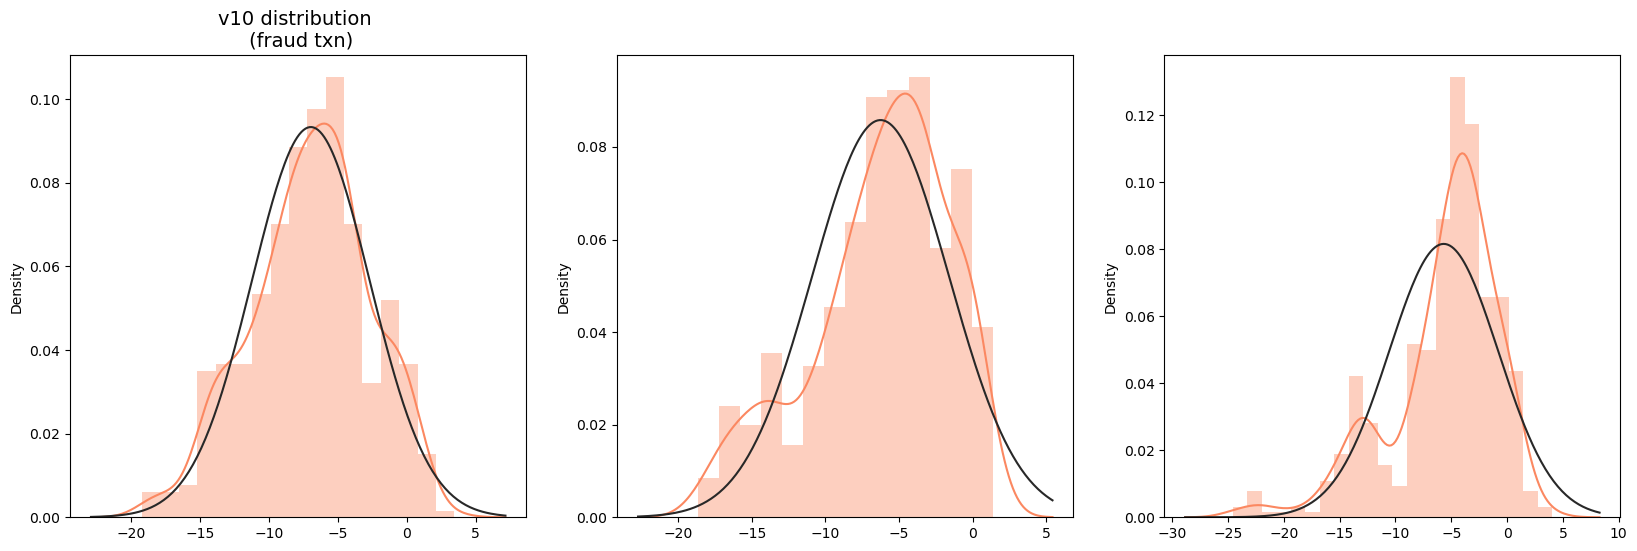

In [48]:
from scipy.stats import norm

f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,6))

v14_fraud_dist = new_df['V14'].loc[new_df['Class']==1].values
sns.distplot(v14_fraud_dist, ax=ax1, fit=norm, color='#FB8861')
ax1.set_title('v14 distribution \n (fraud txn)', fontsize=14)


v12_fraud_dist = new_df['V12'].loc[new_df['Class']==1].values
sns.distplot(v12_fraud_dist, ax=ax2, fit=norm, color='#FB8861')
ax1.set_title('v12 distribution \n (fraud txn)', fontsize=14)

v10_fraud_dist = new_df['V10'].loc[new_df['Class']==1].values
sns.distplot(v10_fraud_dist, ax=ax3, fit=norm, color='#FB8861')
ax1.set_title('v10 distribution \n (fraud txn)', fontsize=14)

plt.show()

In [49]:
# v14 removing outliers (highest negative correlated with labels)
v14_fraud = new_df['V14'].loc[new_df['Class'] == 1].values

q25, q75 = np.percentile(v14_fraud, 25), np.percentile(v14_fraud,75)

print('Quartile 25: {} | Quartile 75: {}'.format(q25, q75))

v14_iqr = q75 - q25
print('iqr : {}'.format(v14_iqr))

Quartile 25: -9.692722964972386 | Quartile 75: -4.282820849486865
iqr : 5.409902115485521


In [50]:
#lf = q1 - 1.5*IQR
#uf = q3 + 1.5*IQR

In [51]:
v14_cutoff = v14_iqr*1.5
v14_lower, v14_upper = q25 - v14_cutoff, q75 + v14_cutoff

print('Cutoff : {}'.format(v14_cutoff))
print('v14 lower : {}'.format(v14_lower))
print('v14 upper : {}'.format(v14_upper))


Cutoff : 8.114853173228282
v14 lower : -17.807576138200666
v14 upper : 3.8320323237414167


In [52]:
outliers = [x for  x in v14_fraud if x < v14_lower or x > v14_upper]
print('Feature v14 outliers for fraud  cases : {}'.format(len(outliers)))
print('v14 outliers : {}'.format(outliers))

Feature v14 outliers for fraud  cases : 4
v14 outliers : [-18.8220867423816, -18.4937733551053, -18.0499976898594, -19.2143254902614]


In [54]:
new_df2 = new_df.drop(new_df[(new_df['V14'] > v14_upper) | (new_df['V14'] < v14_lower)].index)

In [55]:
new_df2.shape

(980, 31)

In [57]:
# v12 removing outliers (highest negative correlated with labels)
v12_fraud = new_df['V12'].loc[new_df['Class'] == 1].values

q25, q75 = np.percentile(v12_fraud, 25), np.percentile(v12_fraud,75)

print('Quartile 25: {} | Quartile 75: {}'.format(q25, q75))

v12_iqr = q75 - q25
print('iqr : {}'.format(v12_iqr))

Quartile 25: -8.67303320439115 | Quartile 75: -2.893030568676315
iqr : 5.780002635714835


In [58]:
v12_cutoff = v12_iqr*1.5
v12_lower, v12_upper = q25 - v12_cutoff, q75 + v12_cutoff

print('Cutoff : {}'.format(v12_cutoff))
print('v12 lower : {}'.format(v12_lower))
print('v12 upper : {}'.format(v12_upper))


Cutoff : 8.670003953572252
v12 lower : -17.3430371579634
v12 upper : 5.776973384895937


In [59]:
outliers = [x for  x in v12_fraud if x < v12_lower or x > v12_upper]
print('Feature v12 outliers for fraud  cases : {}'.format(len(outliers)))
print('v12 outliers : {}'.format(outliers))

Feature v12 outliers for fraud  cases : 4
v12 outliers : [-18.0475965708216, -18.5536970096458, -18.4311310279993, -18.6837146333443]


In [60]:
new_df2 = new_df2.drop(new_df2[(new_df2['V12'] > v12_upper) | (new_df2['V12'] < v12_lower)].index)

In [61]:
new_df2.shape

(976, 31)

In [66]:
# v10 removing outliers (highest negative correlated with labels)
v10_fraud = new_df['V10'].loc[new_df['Class'] == 1].values

q25, q75 = np.percentile(v10_fraud, 25), np.percentile(v10_fraud,75)

print('Quartile 25: {} | Quartile 75: {}'.format(q25, q75))

v10_iqr = q75 - q25
print('iqr : {}'.format(v10_iqr))

Quartile 25: -7.537184847592775 | Quartile 75: -2.53746481466505
iqr : 4.999720032927725


In [67]:
v10_cutoff = v10_iqr*1.5
v10_lower, v10_upper = q25 - v10_cutoff, q75 + v10_cutoff

print('Cutoff : {}'.format(v10_cutoff))
print('v10 lower : {}'.format(v10_lower))
print('v10 upper : {}'.format(v10_upper))


Cutoff : 7.499580049391588
v10 lower : -15.036764896984362
v10 upper : 4.962115234726538


In [68]:
outliers = [x for  x in v10_fraud if x < v10_lower or x > v10_upper]
print('Feature v10 outliers for fraud  cases : {}'.format(len(outliers)))
print('v10 outliers : {}'.format(outliers))

Feature v10 outliers for fraud  cases : 25
v10 outliers : [-23.2282548357516, -16.6011969664137, -16.3035376590131, -22.1870885620007, -18.9132433348732, -15.2318333653018, -22.1870885620007, -17.1415136412892, -15.1241628144947, -15.3460988468775, -22.1870885620007, -18.2711681738888, -22.1870885620007, -16.6496281595399, -16.2556117491401, -15.2399619587112, -16.7460441053944, -15.5637913387301, -19.836148851696, -15.5637913387301, -15.2399619587112, -15.1237521803455, -20.9491915543611, -24.5882624372475, -24.4031849699728]


In [71]:
new_df2 = new_df2.drop(new_df2[(new_df2['V10'] > v10_upper) | (new_df2['V10'] < v10_lower)].index)

In [72]:
new_df2.shape

(949, 31)

Text(0, -12, 'Fewer extreme \n outliers')

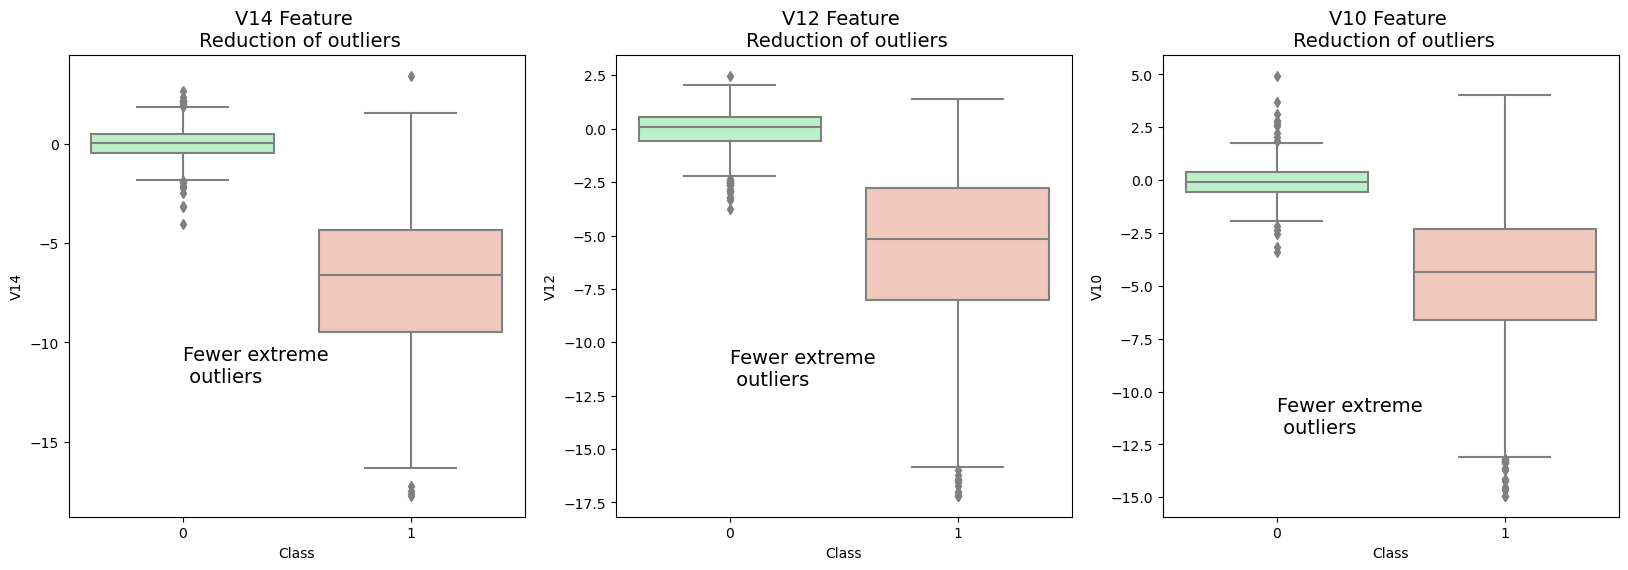

In [78]:
f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,6))

colors = ['#B3F9C5', '#f9c5b3']
# Boxplot with outliers removed
# Feature V14
sns.boxplot(x='Class' , y='V14', data=new_df2, ax=ax1, palette=colors)
ax1.set_title("V14 Feature \n Reduction of outliers", fontsize=14)
ax1.annotate('Fewer extreme \n outliers', xy = (0.98, -17.5), xytext=(0,-12), fontsize=14)

# Feature V12
sns.boxplot(x='Class' , y='V12', data=new_df2, ax=ax2, palette=colors)
ax2.set_title("V12 Feature \n Reduction of outliers", fontsize=14)
ax2.annotate("Fewer extreme \n outliers", xy = (0.98, -17.3), xytext=(0,-12), fontsize=14)

# Feature V10
sns.boxplot(x='Class' , y='V10', data=new_df2, ax=ax3, palette=colors)
ax3.set_title("V10 Feature \n Reduction of outliers", fontsize=14)
ax3.annotate("Fewer extreme \n outliers", xy = (0.98, -14.3), xytext=(0,-12), fontsize=14)


In [79]:
from sklearn.model_selection import train_test_split

train_target = new_df2['Class']
train = new_df2.drop(['Class'], axis=1)
x_train, x_test, y_train, y_test = train_test_split(train, train_target, random_state=0)


In [91]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_curve, auc

from scipy.stats import randint
import pickle
#import xgboost as xgb

In [82]:
class_weight = dict({0:1, 1:100})

random_search = {'criterion' : ['entropy', 'gini'], 
                 'max_depth' : [2,3,4,5,6,7,10],
                'min_samples_leaf' : [4,6,8],
                'min_samples_split' : [5,7,10],
                'n_estimators' : [300]}

clf = RandomForestClassifier(class_weight = class_weight)
model = RandomizedSearchCV(estimator = clf, param_distributions = random_search, n_iter = 10, 
                          cv=4, verbose=1, random_state=101, n_jobs=-1)

model.fit(x_train, y_train)

Fitting 4 folds for each of 10 candidates, totalling 40 fits


RandomizedSearchCV(cv=4,
                   estimator=RandomForestClassifier(class_weight={0: 1,
                                                                  1: 100}),
                   n_jobs=-1,
                   param_distributions={'criterion': ['entropy', 'gini'],
                                        'max_depth': [2, 3, 4, 5, 6, 7, 10],
                                        'min_samples_leaf': [4, 6, 8],
                                        'min_samples_split': [5, 7, 10],
                                        'n_estimators': [300]},
                   random_state=101, verbose=1)

In [86]:
y_pred = model.predict(x_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.92      0.98      0.95       125
           1       0.97      0.91      0.94       113

    accuracy                           0.95       238
   macro avg       0.95      0.94      0.95       238
weighted avg       0.95      0.95      0.95       238



In [87]:
y_score = model.predict_proba(x_test)[:,1]

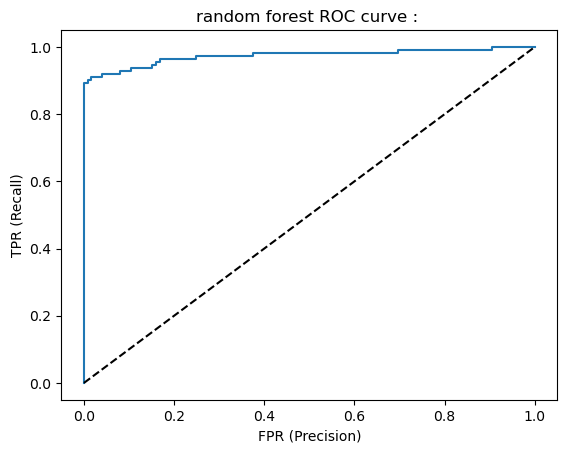

Area under curve AUC :  0.9738761061946902


In [92]:
fpr, tpr, _ = roc_curve(y_test, y_score)

plt.title('random forest ROC curve : ')
plt.xlabel('FPR (Precision)')
plt.ylabel('TPR (Recall)')

plt.plot(fpr, tpr)
plt.plot((0,1), ls='dashed', color='black')
plt.show()
print('Area under curve AUC : ', auc(fpr, tpr))